## Microlensing within SLSim
### Author: [Paras Sharma](https://github.com/timedilatesme)

### For running on Seawulf cluster
```bash
module load slurm
srun -J [job_name] -N 1 -p a100 --gpus=1 --pty bash
module load cuda120/toolkit/12.0
jupyter notebook --ip=0.0.0.0 --no-browser --port=8888
```

In [1]:
from slsim.Microlensing.magmap import MagnificationMap
from slsim.Microlensing.lightcurve import MicrolensingLightCurve
from matplotlib import pyplot as plt
import numpy as np
from slsim.Microlensing.lightcurve import MicrolensingLightCurveFromLensModel

# might not need all of these
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop

# import numpy as np
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.QuasarCatalog.quasar_pop import QuasarRate

# import matplotlib.pyplot as plt
# from slsim.image_simulation import (
#     point_source_coordinate_properties,
#     lens_image_series,
#     rgb_image_from_image_list,
# )
# from slsim.Plots.plot_functions import create_image_montage_from_image_list
# from lenstronomy.LensModel.lens_model import LensModel

### 1. Microlensing Map Generation

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.077 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.084 seconds.

Shooting cells...
100 %

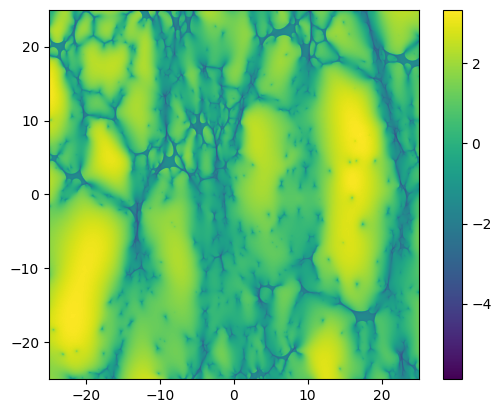

In [2]:
magmap = MagnificationMap(
    kappa_tot=3,
    shear=1,
    kappa_star=1,
    rectangular=True,
    half_length_x=25,
    half_length_y=25,
    mass_function="kroupa",
    m_lower=0.08,
    m_upper=100,
    num_pixels_x=5000,
    num_pixels_y=5000,
)
plt.imshow(
    magmap.magnitudes,
    origin="lower",
    extent=[
        -magmap.half_length_x,
        magmap.half_length_x,
        -magmap.half_length_y,
        magmap.half_length_y,
    ],
)
plt.colorbar()

### 2. Light Curve Extraction Using a Microlensing Map

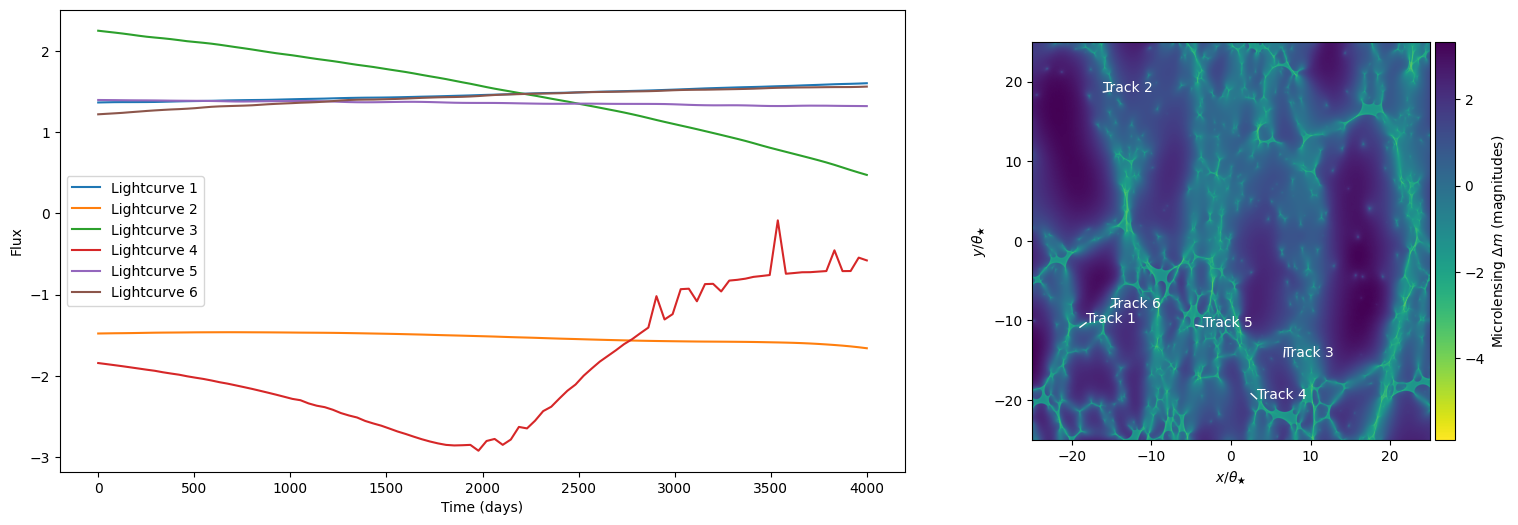

In [4]:
# from slsim.Microlensing.magmap import MagnificationMap
# from slsim.Microlensing.lightcurve import MicrolensingLightCurve

# magmap = MagnificationMap(
#     kappa_tot=3,
#     shear=1,
#     kappa_star=1,
#     rectangular=True,
#     half_length_x=25,
#     half_length_y=25,
#     mass_function="kroupa",
#     m_lower=0.08,
#     m_upper=100,
#     num_pixels_x=5000,
#     num_pixels_y=5000,
# )

ml_lc = MicrolensingLightCurve(magmap, time_duration=4000)
LCs, tracks = ml_lc._generate_agn_lightcurve(
    3, 1, return_track_coords=True, num_lightcurves=6
)
ml_lc._plot_agn_lightcurve(LCs, tracks, lightcurve_type="flux")

### 3. Light Curve Extraction for images of point sources in the Lens Class

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
galaxy_sky_area = Quantity(value=1, unit="deg2")
quasar_sky_area = Quantity(value=1, unit="deg2")
full_sky_area = Quantity(value=5, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 5.0}

# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=galaxy_sky_area, filters=None, cosmo=cosmo
)

# Initiate deflector population class
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
)

# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 5.01, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
quasar_source = quasar_class.quasar_sample(m_min=15, m_max=30)

# Prepare dictionary of agn variability kwargs
variable_agn_kwarg_dict = {
    "length_of_light_curve": 500,  # TODO: Ask Narayan => length of light curve in days?
    "time_resolution": 1,
    "log_breakpoint_frequency": 1 / 20,
    "low_frequency_slope": 1,
    "high_frequency_slope": 3,
    "standard_deviation": 0.9,
}
# Initiate source population class.
source_quasar = sources.PointSources(
    quasar_source,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    light_profile=None,
    variability_model="light_curve",  # keyword for the variability model.
    kwargs_variability_model={"agn_lightcurve", "i", "g", "r"},  # specify kewords for
    agn_driving_variability_model="bending_power_law",
    agn_driving_kwargs_variability=variable_agn_kwarg_dict,
    lightcurve_time=np.linspace(0, 1000, 500),
)

# Initiate LensPop class to generate lensed quasar pop.
quasar_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_quasar,
    cosmo=cosmo,
    sky_area=full_sky_area,
)

kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

In [3]:
# Select a random lens
kwargs_lens_cut = {"min_image_separation": 2, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = quasar_lens_pop.select_lens_at_random(**kwargs_lens_cut)

In [4]:
lens_class.point_source_image_positions()

[(array([-1.66756062,  1.39682515, -0.62802053,  0.65666213]),
  array([ 0.58958598, -0.6855498 , -1.34957937,  1.37135122]))]

In [6]:
ml_lc_lens = MicrolensingLightCurveFromLensModel(lens_class)
LCs_lens, tracks_lens, time_arrays = ml_lc_lens._generate_agn_lightcurve(
    band="i", source_class=lens_class.source[0]
)

keyword corona_height is not defined, using default value of: 10
keyword r_resolution is not defined, using default value of: 500

Done shooting cells. Elapsed time: 1.001 seconds.

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.072 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.073 seconds.

Shooting cells...
100 %
Done shooting cells. Elapsed time: 3.553 seconds.

Generating star field...
Done generating star field. Elapsed time: 0 seconds.

Creating children and sorting stars...
Done creating children and sorting stars. Elapsed time: 0.089 seconds.

Calculating multipole and local coefficients...
Done calculating multipole and local coefficients. Elapsed time: 0.097 seconds.

Shooting cells...
100 %
Done shooting cells. Elapsed time: 12.119 seconds.

Generating star field...
Done

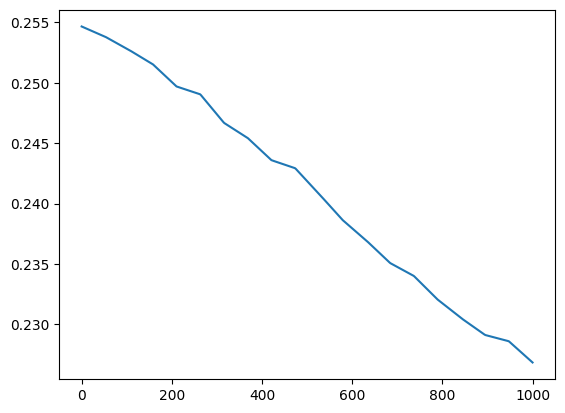

In [7]:
plt.plot(time_arrays[1][0], LCs_lens[1][0])

### TEST CODE

Text(0.5, 1.0, 'Convolved Image')

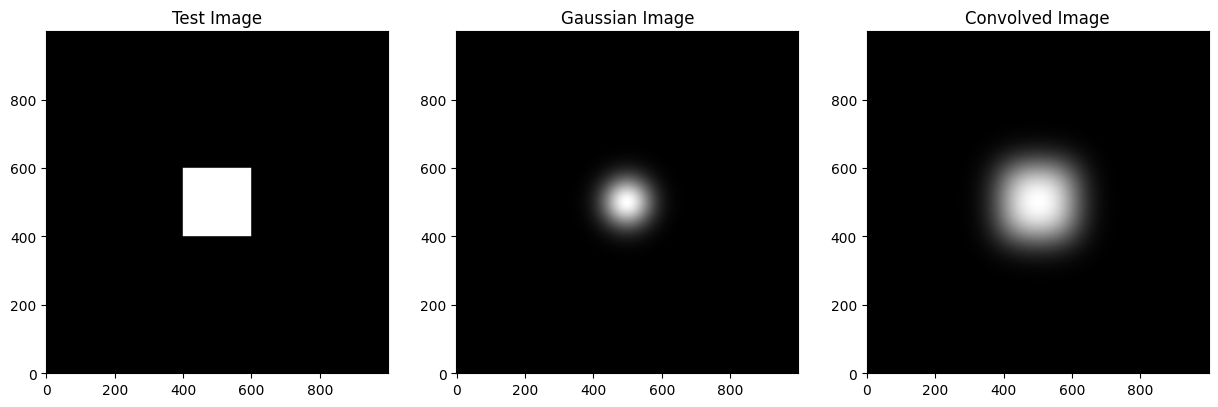

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal as signal

num_pixels = 1000

x, y = np.meshgrid(
    np.linspace(-10, 10, num_pixels), np.linspace(-10, 10, num_pixels)
)  # create a grid of points
sigma = 1  # standard deviation of the Gaussian
gaussian_img = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(
    -((x**2 + y**2) / (2 * sigma**2))
)  # Gaussian function

test_img = np.zeros((num_pixels, num_pixels))
test_img[
    num_pixels // 2 - 100 : num_pixels // 2 + 100,
    num_pixels // 2 - 100 : num_pixels // 2 + 100,
] = 1  # create a point source in the center

convolved_img = signal.fftconvolve(
    test_img, gaussian_img, mode="same"
)  # convolve the point source with the Gaussian

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(test_img, cmap="gray", origin="lower")
ax[0].set_title("Test Image")
ax[1].imshow(gaussian_img, cmap="gray", origin="lower")
ax[1].set_title("Gaussian Image")
ax[2].imshow(convolved_img, cmap="gray", origin="lower")
ax[2].set_title("Convolved Image")

In [15]:
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM


def theta_E(
    # z_lens,
    # z_source,
    M_lens,
    D_lens_source,
    D_lens,
    D_source,
):
    """
    Calculate the Einstein radius in arcseconds.
    """
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    # D_lens_source = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)
    # D_lens = cosmo.angular_diameter_distance(z_lens)
    # D_source = cosmo.angular_diameter_distance(z_source)

    theta_E = (
        np.sqrt(
            4 * const.G * M_lens / (const.c**2) * D_lens_source / (D_lens * D_source)
        )
        * u.rad
    )
    theta_E = theta_E.to(u.arcsec)

    return theta_E

In [16]:
theta_E(
    # z_lens=0.5,
    # z_source=3.0,
    M_lens=1 * u.M_sun,
    D_lens_source=1 * u.m,
    D_lens=1 * u.m,
    D_source=10 * u.kpc,
)

<Quantity 0.00090243 arcsec>

In [17]:
from slsim.Microlensing.lightcurve import extract_light_curve

In [ ]:
extract_light_curve(
    convolved_img,
    pixel_size= /1000,
    light_curve_time_in_years=10,
)

In [22]:
(((cosmo.kpc_proper_per_arcmin(1)).to(u.kpc / u.arcsec) * 1 * u.arcsec).to(u.m)).value

2.471228772590446e+20

In [28]:
lens_class.deflector.mass_model_lenstronomy(lens_class._lens_cosmo)

(['SIE'],
 [{'theta_E': 1.7156898779401708,
   'e1': -0.03862740911858573,
   'e2': 0.1361354837027775,
   'center_x': -0.060687770794160746,
   'center_y': 0.06672991178938772}])

In [32]:
lens_class.point_source_image_positions()[0]

(array([-1.66756062,  1.39682515, -0.62802053,  0.65666213]),
 array([ 0.58958598, -0.6855498 , -1.34957937,  1.37135122]))

In [33]:
lens_class.cosmo

FlatLambdaCDM(name=None, H0=<Quantity 70. km / (Mpc s)>, Om0=0.3, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=None)